<a href="https://colab.research.google.com/github/Mateusz0W/Inflation-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from process_data import combine_model_args,add_target_inflations,normalize_and_split_data_chronologically,prepare_inference_data, prepare_training_data
from load_data import load_avarage_salary,load_building_price,load_inflation,load_unemployed,load_notional_amount
from evaluate_model import plot_predicted_inflation, calculate_metrics, print_table
from sklearn.neural_network import MLPRegressor

/content/load_data.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


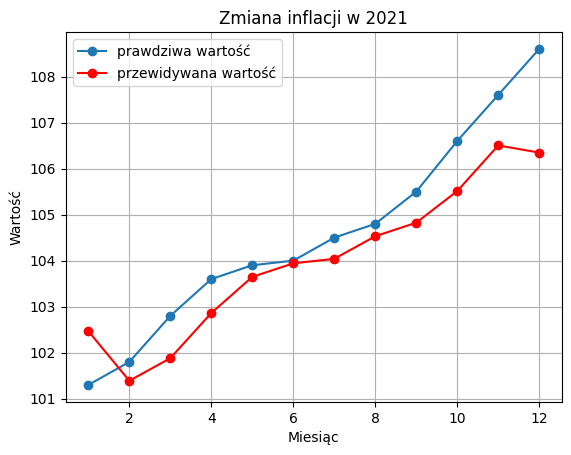

R2=0.7914462786433041, MSE=0.9328723819463529, RMSE=np.float64(0.9658531886090934), MAPE=0.007429754380220526


In [76]:
inflation_steps = [1]
steps = [1]
model_args_indices_tab = [[0]]
start_years = [1995]
end_years = [2020]
inference_years = [2021]
models = [MLPRegressor(solver='adam',hidden_layer_sizes=(15, 15), max_iter = 3_000, tol = 1e-3, activation = 'relu')]

loop_parameters = zip(inflation_steps, steps, model_args_indices_tab, start_years,
                      end_years, inference_years, models)
for inflation_step, step, indices, start_year, end_year, inference_year, model in loop_parameters:
    inflation_dict = load_inflation(step = inflation_step)
    target_inflation_dict = {key: inflation_dict[key][1] for key in inflation_dict}
    inflation_to_last_year_dict = {key: inflation_dict[key][0][:inflation_step] for key in inflation_dict}
    inflation_to_last_month_dict = {key: inflation_dict[key][0][inflation_step:] for key in inflation_dict}
    unemployed_dict = load_unemployed(step = step)
    building_price_dict = load_building_price(step = step)
    average_salary_dict = load_avarage_salary(step = step)
    notional_amount = load_notional_amount(step=step)
    args_dict_tab = [inflation_to_last_year_dict, inflation_to_last_month_dict,
                    unemployed_dict, building_price_dict, average_salary_dict,
                     notional_amount]
    model_args_tab = []
    for index in indices:
        model_args_tab.append(args_dict_tab[index])
    final_data = prepare_training_data(model_args_tab, target_inflation_dict, start_year, end_year)
    X_train, X_test, y_train, y_test, scaler = normalize_and_split_data_chronologically(final_data, test_size=0.1)
    model.fit(X_train, y_train)

    final_data = prepare_training_data(model_args_tab, target_inflation_dict, inference_year, inference_year)
    X, y = prepare_inference_data(final_data, scaler)
    y_pred = model.predict(X)
    plot_predicted_inflation(y,y_pred,inference_year)
    R2, MSE, RMSE, MAPE = calculate_metrics(X,y,model)
    print(f"{R2=}, {MSE=}, {RMSE=}, {MAPE=}")